In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import healpy as hp
import numpy as np
import h5py, os

from astropy.io import fits
from functools import reduce

from msfm.utils.input_output import read_yaml

In this notebook, the `.h5` file containing the correct pixel indices for all of the masks used in the project are generated

Based off [KiDS_1000_index_file.ipynb](https://cosmo-gitlab.phys.ethz.ch/jafluri/arne_handover/-/blob/main/carpet/notebooks/KiDS_1000_index_file.ipynb) by Janis Fluri.

### global constants

In [2]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

pixels_dir = f"../../data/DESY3_pixels_{n_side}.h5"

# Transformations

### Rotations

In [3]:
# these are the standard rotation matrices

def get_rot_x(ang):
    return np.array([[1.0, 0.0,         0.0],
                     [0.0, np.cos(ang), -np.sin(ang)],
                     [0.0, np.sin(ang), np.cos(ang)]]).T # Inverse because of healpy

def get_rot_y(ang):
    return np.array([[np.cos(ang),  0.0, np.sin(ang)],
                     [0.0,          1.0, 0.0],
                     [-np.sin(ang), 0.0, np.cos(ang)]]).T # Inverse because of healpy

def get_rot_z(ang):
    return np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang), np.cos(ang),  0.0],
                     [0.0,         0.0,          1.0]]).T # Inverse because of healpy

In [4]:
# these rotation angles were found by trial and error
y_rot = get_rot_y(-0.125)
z_rot = get_rot_z(-1.22)

### HEALPix Symmetry transformations

In [5]:
# let's try to mirror it (up down)
def mirror_pix(pix, nside=n_side, lr=False):
    theta, phi = hp.pix2ang(ipix=pix, nside=nside)
    if lr:
        phi = 2*np.pi - phi
    else:
        theta = np.pi - theta
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)
    # we make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))
    return new_pix

# now 90 degree rotations
def rotate_pix(pix, n_rot=1, nside=n_side):
    theta, phi = hp.pix2ang(ipix=pix, nside=nside)
    phi = (phi + n_rot*np.pi/2) % (2*np.pi)
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)
    # we make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))
    return new_pix

# Metacal

In [6]:
# exclude the 0th bin, which includes all of the others
tomo_inds = [1, 2, 3, 4]
z_lims = conf["survey"]["metacal"]["z_lims"]
z_bins = conf["survey"]["metacal"]["z_bins"]

### load Metacal catalog

In [7]:
# data given by Dominik
data_dir = '/Users/arne/data/DESY3/DES_Y3KP_NGSF/'

pix_list = []
vec_list = []
# consider all tomographic bins
for tomo in tomo_inds:
    # J2000 angles in degrees
    alpha = h5py.File(os.path.join(data_dir, f'ALPHAWIN_J2000_tomo={tomo}.h5'))['ALPHAWIN_J2000'][:]
    delta = h5py.File(os.path.join(data_dir, f'DELTAWIN_J2000_tomo={tomo}.h5'))['DELTAWIN_J2000'][:]

    # angles like in healpy in radian
    theta = -np.deg2rad(delta) + np.pi/2
    phi = np.deg2rad(alpha)

    # derived pixel ids, shape (num_galaxies,)
    pix = hp.ang2pix(nside=n_side, theta=theta, phi=phi)

    # vector positions of the galaxies, shape (num_galaxies, 3)
    vec = hp.ang2vec(theta=theta, phi=phi)

    pix_list.append(pix)
    vec_list.append(vec)

### original masks


bin desy3metacal1
n_gal = 24940465
n_pix = 370313

bin desy3metacal2
n_gal = 25280405
n_pix = 370333

bin desy3metacal3
n_gal = 24891859
n_pix = 370322

bin desy3metacal4
n_gal = 25091297
n_pix = 370091


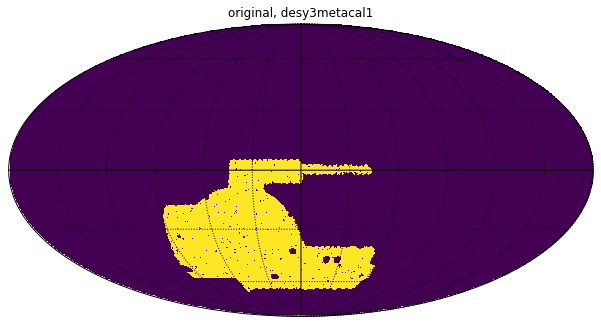

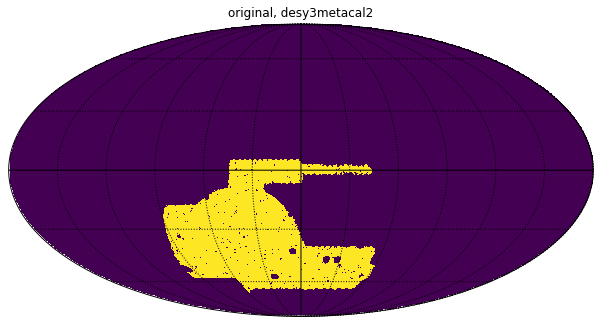

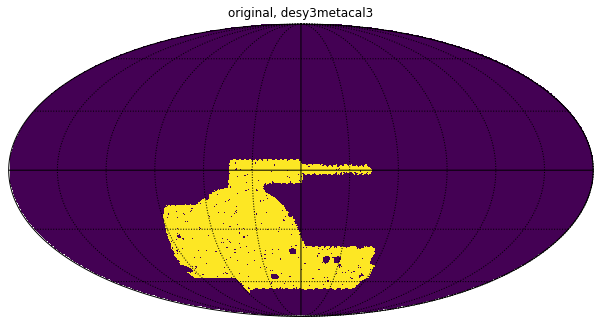

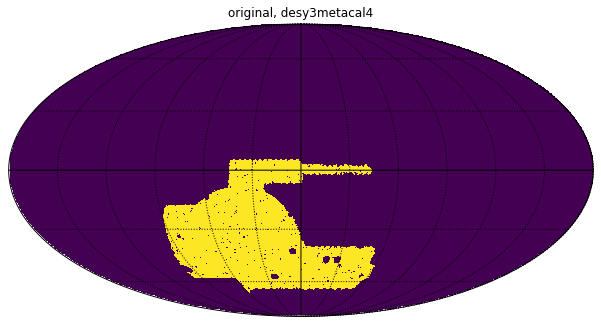

In [8]:
for pix, name in zip(pix_list, z_bins):
    print(f"\nbin {name}")

    z_mask = np.zeros(n_pix)
    z_mask[pix] = 1
    hp.mollview(z_mask, title=f"original, {name}", cbar=False)
    hp.graticule()

    print(f"n_gal = {len(pix)}")
    print(f"n_pix = {np.sum(z_mask, dtype=int)}")

### rotated masks

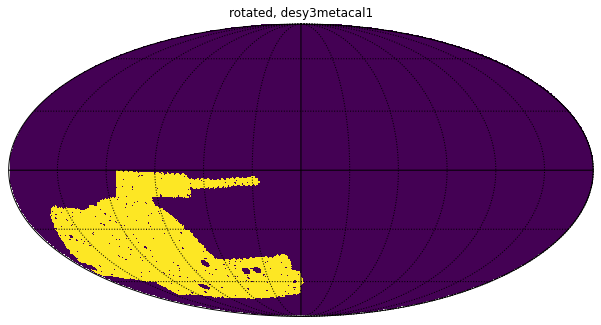

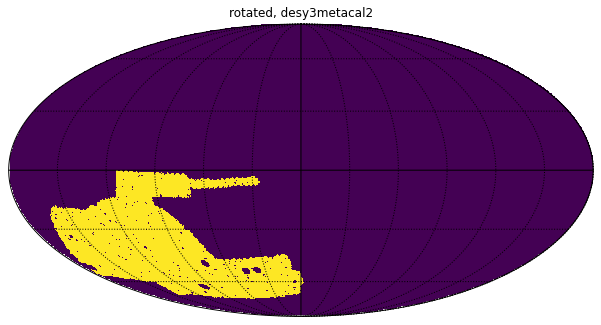

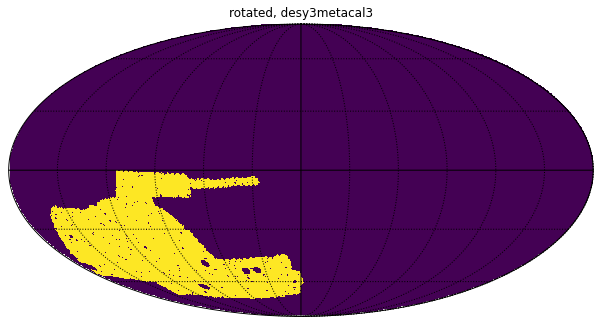

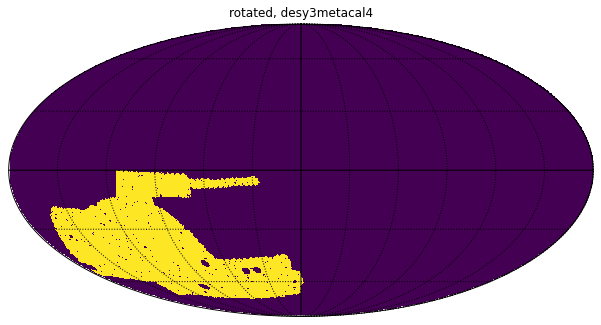

In [9]:
rot_pix_ring_list = []
rot_pix_nest_list = []

# loop over tomographic bins
for vec, name in zip(vec_list, z_bins):
    # vec.shape = (n_galaxies, 3)
    rotated_vec = np.dot(y_rot, vec.T)

    # rotated_vec.shape = (3, n_galaxies)
    rotated_vec = np.dot(z_rot, rotated_vec)

    # convert the vectors to pixels
    rot_pix_ring = hp.vec2pix(n_side, rotated_vec[0], rotated_vec[1], rotated_vec[2])
    rot_pix_nest = hp.vec2pix(n_side, rotated_vec[0], rotated_vec[1], rotated_vec[2], nest=True)

    rot_pix_ring_list.append(rot_pix_ring)
    rot_pix_nest_list.append(rot_pix_nest) 

    # plot the rotated mask
    rot_mask = np.zeros(n_pix)
    rot_mask[rot_pix_ring] = 1
    hp.mollview(rot_mask, title=f"rotated, {name}", cbar=False)
    hp.graticule()

In [10]:
# loop over tomographic bins and remove double counting
footprint_ring_list = []
footprint_nest_list = []
for rot_pix_ring, rot_pix_nest in zip(rot_pix_ring_list, rot_pix_nest_list):
    footprint_ring_list.append(np.unique(rot_pix_ring))
    footprint_nest_list.append(np.unique(rot_pix_nest))

In [11]:
non_tomo_patches_pix = reduce(np.intersect1d, (footprint_ring_list))


In [12]:
non_tomo_patches_pix.shape

(369764,)

In [13]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    base_grp = f.create_group("metacal/masks")

    ring_grp = base_grp.create_group("RING")
    nest_grp = base_grp.create_group("NEST")
    for rot_pix_ring, rot_pix_nest, name in zip(footprint_ring_list, footprint_nest_list, z_bins):        
        dset = ring_grp.create_dataset(name, shape=rot_pix_ring.shape, dtype="i", data=rot_pix_ring)
        dset.attrs["info"] = "This dataset contains all pixel ids for a map with nside " \
                             f"{n_side} in RING ordering, rotated such that one can use " \
                             "HEALPIX symmetry transformations to extract more patches. " \
                             "Each pixel is contained only once, so it is a patch to " \
                             "cutout from a full sky map. "

        dset = nest_grp.create_dataset(name, shape=rot_pix_nest.shape, dtype="i", data=rot_pix_nest)
        dset.attrs["info"] = "This dataset contains all pixel ids for a map with nside " \
                             f"{n_side} in NEST ordering, rotated such that one can use " \
                             "HEALPIX symmetry transformations to extract more patches. " \
                             "Each pixel is contained only once, so it is a patch to " \
                             "cutout from a full sky map. "

    # include non tomographic version, the intersection
    non_tomo_rot_pix_ring = reduce(np.intersect1d, (footprint_ring_list))
    dset = ring_grp.create_dataset("non_tomo", dtype="i", data=non_tomo_rot_pix_ring)

### all patches for all bins

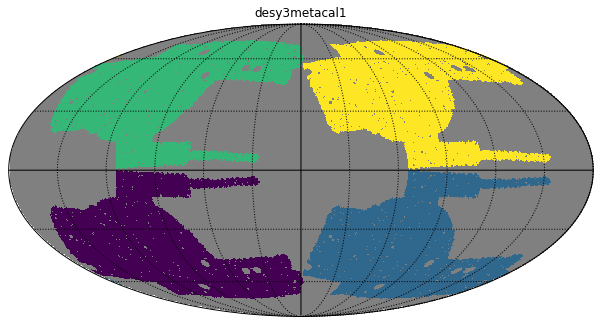

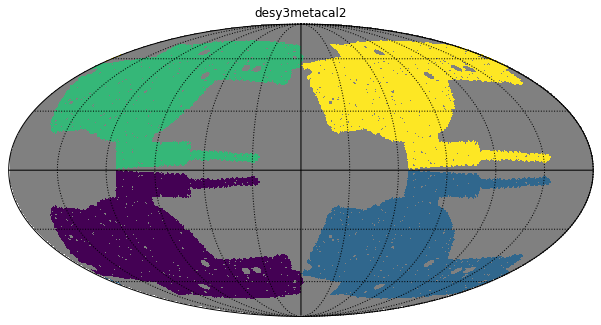

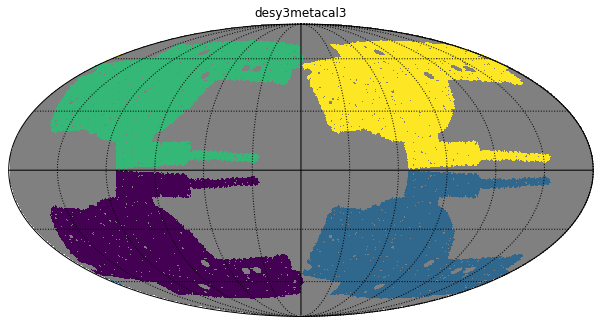

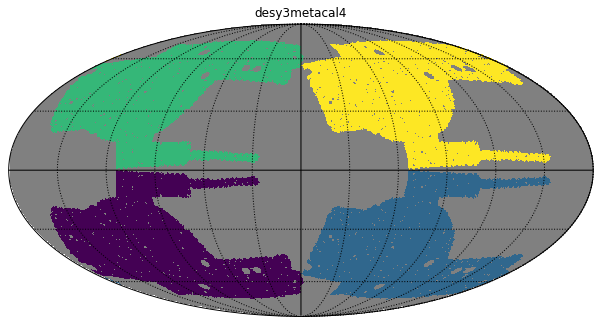

In [15]:
# loop over the the tomographic bins
patches = []
for patch_0, name in zip(footprint_ring_list, z_bins):
    # perform symmetry transformations
    patch_1 = rotate_pix(patch_0, n_rot=2)
    patch_2 = mirror_pix(patch_0, lr=False)
    patch_3 = mirror_pix(patch_0, lr=False)
    patch_3 = rotate_pix(patch_3, n_rot=2)

    # all patches have the same size
    assert len(patch_0) == len(patch_1) == len(patch_2) == len(patch_3)
    # no index occurs more than once
    assert reduce(np.intersect1d, ([patch_0, patch_1, patch_2, patch_3])).size == 0

    patches.append(np.stack([patch_0, patch_1, patch_2, patch_3]))

    # plot the total mask
    full_mask = np.full(n_pix, hp.UNSEEN)
    full_mask[patch_0] = 0
    full_mask[patch_1] = 1
    full_mask[patch_2] = 2
    full_mask[patch_3] = 3

    hp.mollview(full_mask, title=name, cbar=False)
    hp.graticule()

In [16]:
# check the shapes, i.e. number of pixels for each patch
print([p.shape for p in patches])

[(4, 371012), (4, 370979), (4, 370982), (4, 370671)]


In [17]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    base_grp = f.create_group("metacal/map_cut_outs")
    base_grp.attrs["info"] = "This group contains all datasets necessary to efficently cut " \
                             "out 4 patches of the DES Y3 data for all five tomographic bins " \
                             "and package it for a TFR file. " \
                             "The idea is the following: " \
                             "One can create a data vector out of zeros (for the padding) and then " \
                             "add the data by doing data_vec[RING_ids_to_data_vec_bin_{i_bin}] " \
                             "m[patch_ids_RING_tomo_{i_bin}[j]] where j runs over all 4 patches and " \
                             "m is the map to extract data from, the other vectors indicate datasets."

    grp = base_grp.create_group("patches")
    grp = grp.create_group("RING")
    for patch, name in zip(patches, z_bins):
        dset = grp.create_dataset(name, shape=patch.shape,
                                  dtype="i", data=patch)
        dset.attrs["info"] = "This dataset contains all pixel ids for a map with nside " \
                             f"{n_side} in RING ordering, to cut out 4 DES Y3 data patches simulataneously. " \
                             "The shape is (N_patches, N_pix), first patch is the original one. " \
                             f"Data is for tomo bin: {name}"

### Do some cutouts for testing

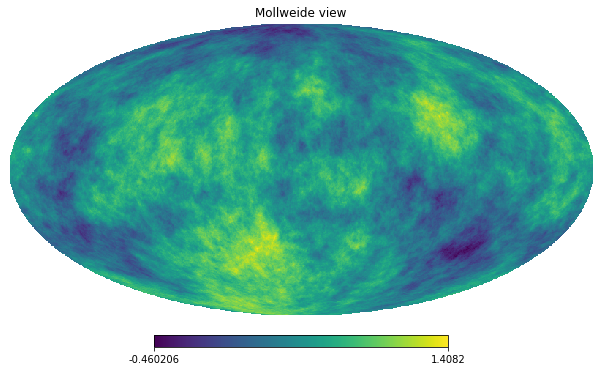

In [18]:
# we start be generating a random map
np.random.seed(11)
Cl = np.arange(1, 1001)**-3.
example_map = hp.synfast(cls=Cl, nside=n_side)

z_min = np.min(example_map)
z_max = np.max(example_map)

# plot
hp.mollview(example_map, min=z_min, max=z_max)


desy3metacal1
patch 0
patch 1
patch 2
patch 3

desy3metacal2
patch 0
patch 1
patch 2
patch 3

desy3metacal3
patch 0
patch 1
patch 2
patch 3

desy3metacal4
patch 0
patch 1
patch 2
patch 3


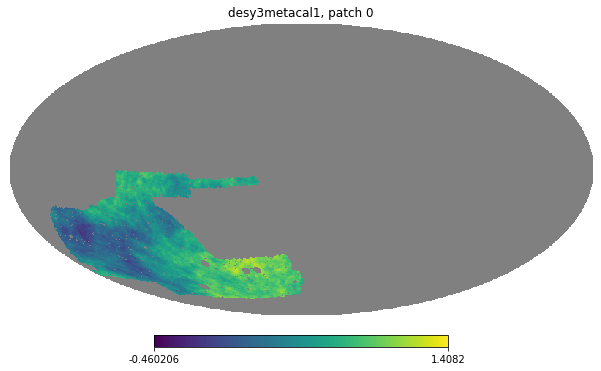

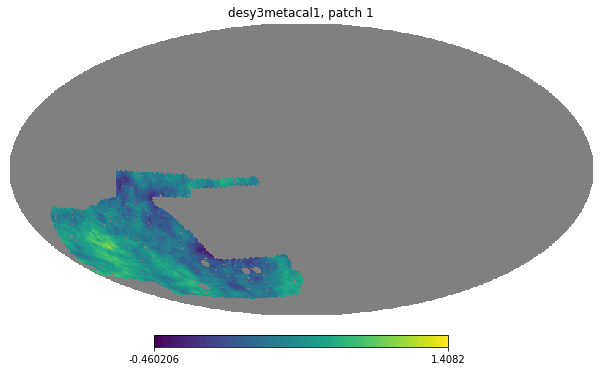

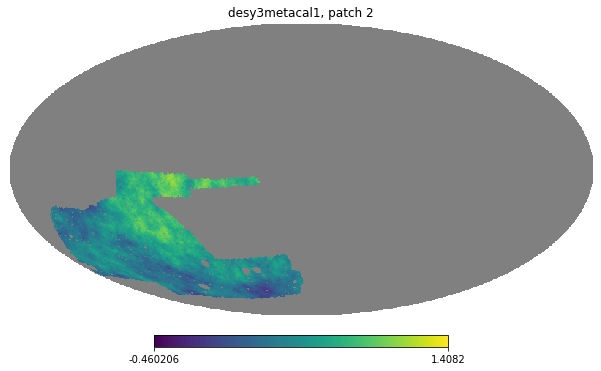

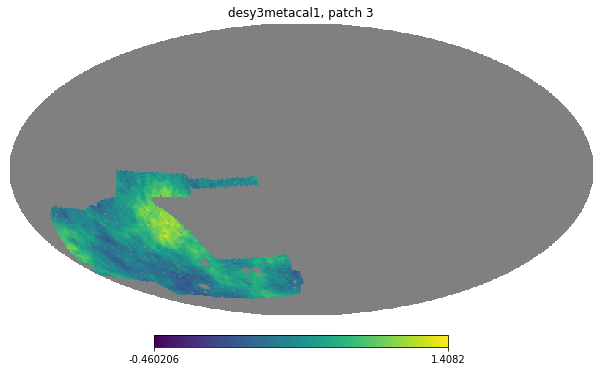

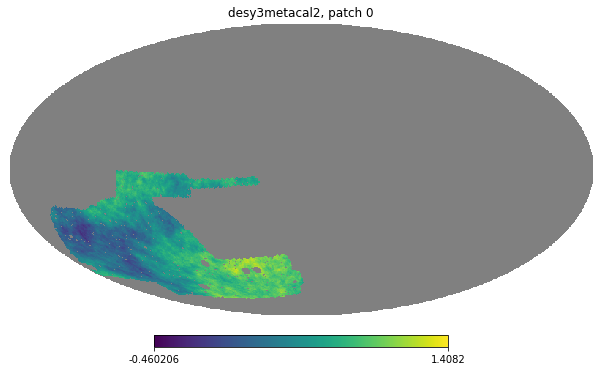

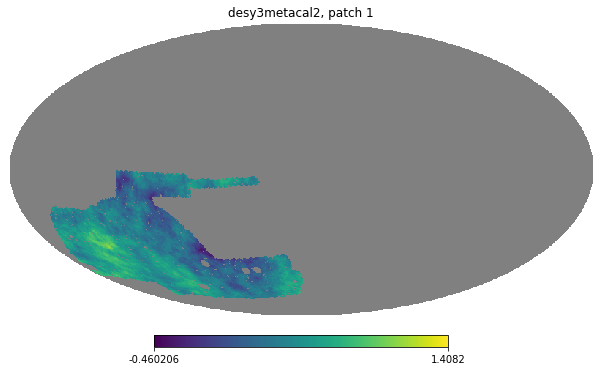

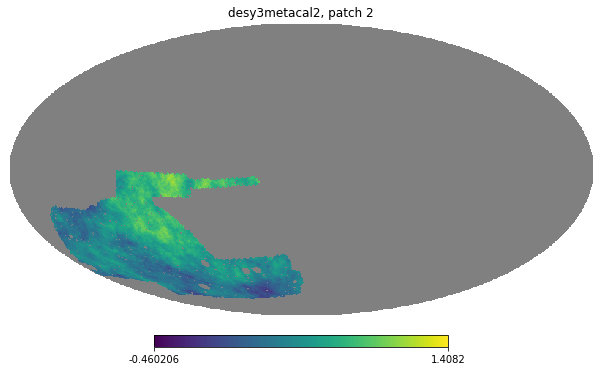

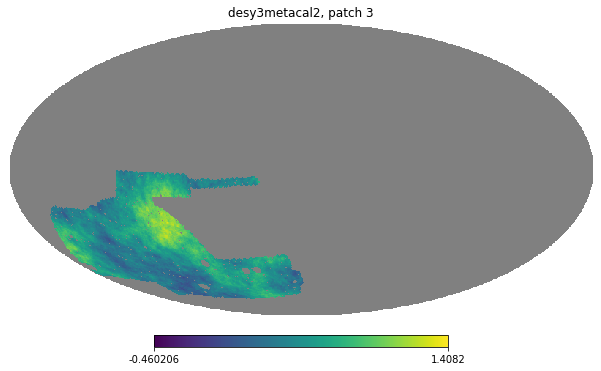

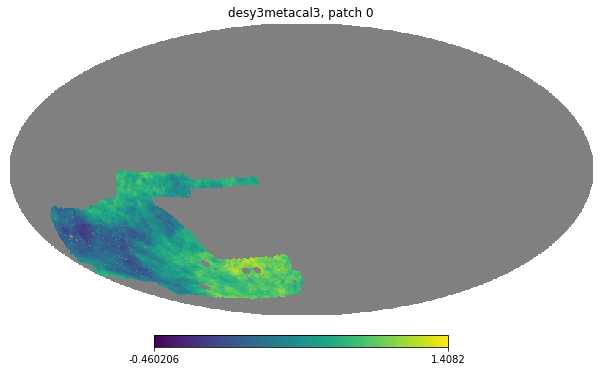

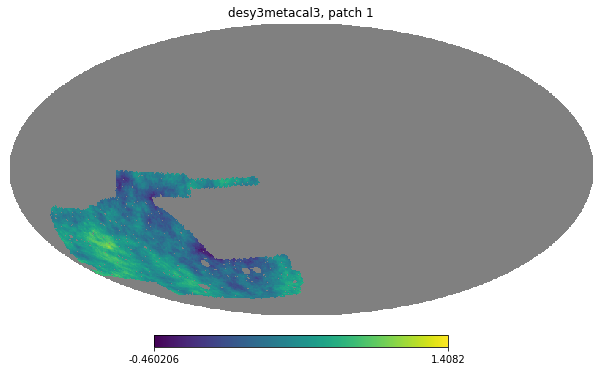

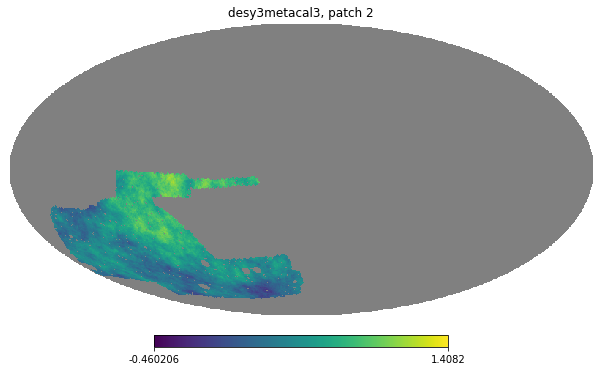

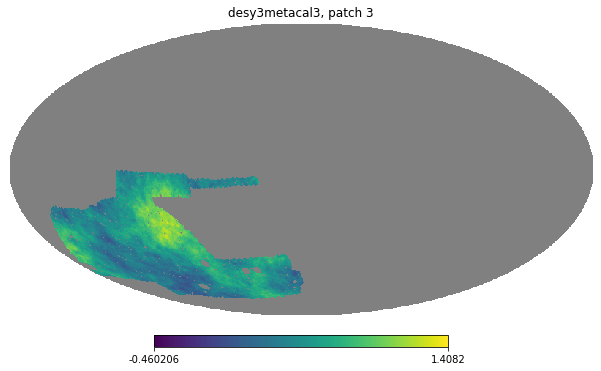

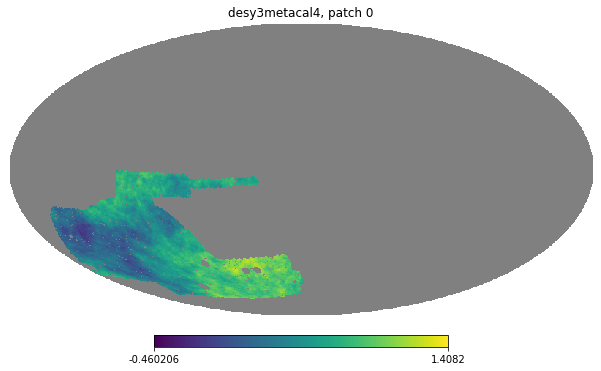

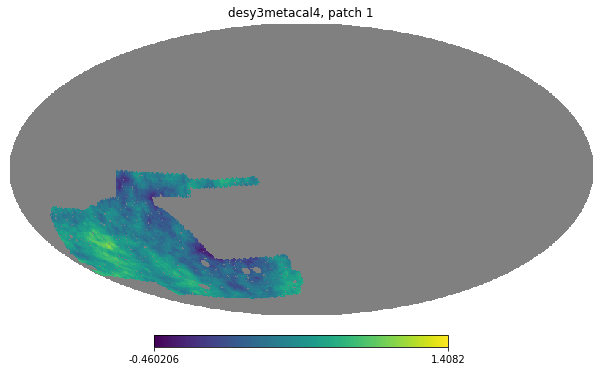

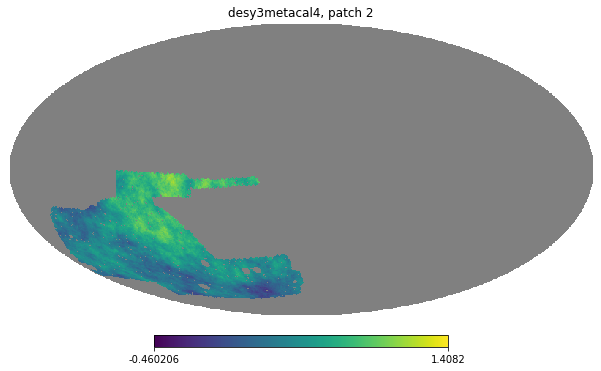

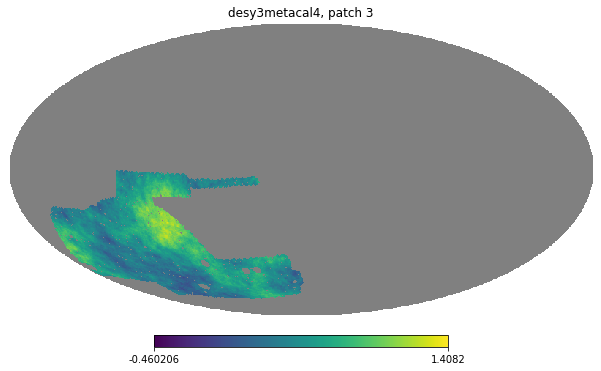

In [19]:
# let's cut out everything
for patch, name in zip(patches, z_bins):
    print(f"\n{name}")

    base_indices = patch[0]

    for j, indices in enumerate(patch):
        print(f"patch {j}")
        m_plot = np.full(n_pix, hp.UNSEEN)
        m_plot[base_indices] = example_map[indices]
        hp.mollview(m_plot, min=z_min, max=z_max, title=f"{name}, patch {j}")

### Extend the indices, i.e. padding for network

union has 371871
desy3metacal1 has length 371012
desy3metacal2 has length 370979
desy3metacal3 has length 370982
desy3metacal4 has length 370671


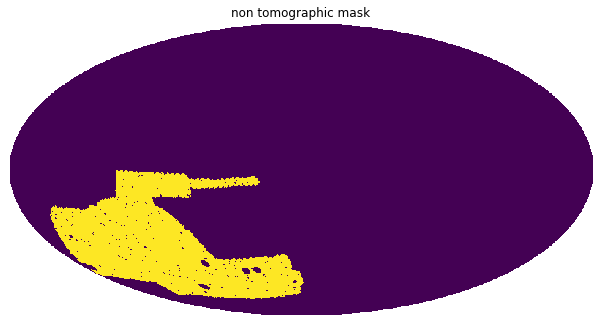

In [20]:
# get the non-tomo mask in NEST
non_tomo_pixels_nest = reduce(np.union1d, footprint_nest_list)

print(f"union has {len(non_tomo_pixels_nest)}")
for footprint, name in zip(footprint_nest_list, z_bins):
    print(f"{name} has length {len(footprint)}")
    assert len(non_tomo_pixels_nest) > len(footprint)

# plot the corresponding mask
non_tomo_mask_nest = np.zeros(n_pix)
non_tomo_mask_nest[non_tomo_pixels_nest] = 1
hp.mollview(non_tomo_mask_nest, nest=True, cbar=False, title="non tomographic mask")

In [21]:
# minimal possible nside for the network to downsample
nside_down = 16
padded_mask_nest = hp.ud_grade(non_tomo_mask_nest, nside_out=nside_down, 
                                 order_in='NEST', order_out='NEST')
padded_mask_nest[padded_mask_nest > 0] = 1
print(f"nside={nside_down}, npix={np.sum(padded_mask_nest)}")

padded_mask_nest = hp.ud_grade(padded_mask_nest, nside_out=n_side,
                                 order_in='NEST', order_out='NEST')
padded_mask_nest[padded_mask_nest > 0] = 1
print(f"nside={n_side}, npix={np.sum(padded_mask_nest)}")

nside=16, npix=453.0
nside=512, npix=463872.0


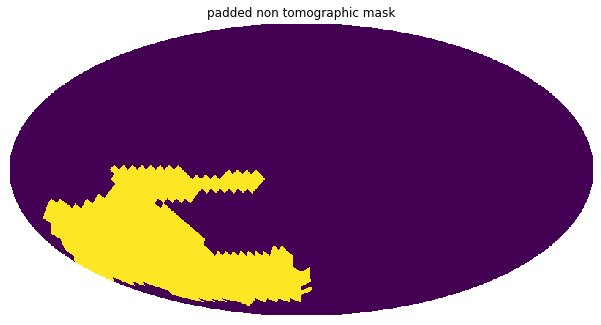

In [22]:
# check the padded patch
hp.mollview(padded_mask_nest, nest=True, title="padded non tomographic mask", cbar=False)

In [23]:
# get the pixel in nest ordering (from the mask on map level)
non_tomo_pixels_nest_ext = np.arange(n_pix)[padded_mask_nest > 0.5]
print(len(non_tomo_pixels_nest))
print(len(non_tomo_pixels_nest_ext))
assert len(non_tomo_pixels_nest_ext) > len(non_tomo_pixels_nest)

371871
463872


In [24]:
# save the indices
with h5py.File(pixels_dir, "a") as f:
    grp = f["metacal/map_cut_outs"]
    dset = grp.create_dataset("data_vec_ids", shape=non_tomo_pixels_nest_ext.shape,
                              dtype="i", data=non_tomo_pixels_nest_ext)
    dset.attrs["info"] = "This dataset contains all relevant pixels from the original rotated " \
                         "DES Y3 patch in NEST ordering, such that it can be downsampled to " \
                         f"an nside of {nside_down} without the need of additional padding."

### Note:

Now comes the tricky part:

The idea for a fast and efficient cut out procedure of the simulated maps is that one can generate data vectors that only consist of zeros (including the padding) and then fill in the necessary pixels. To make this possible, we need to know the correspondence of the pixels inside the data vector (NEST ordering) with pixels in RING ordering of the full sky map.

In [25]:
# dict for fast look up
non_tomo_pixels_nest_ext_look_up = {}
for i, pix_id in enumerate(non_tomo_pixels_nest_ext):
    non_tomo_pixels_nest_ext_look_up.update({pix_id: i})

# list for correspondences
map_to_datavec_pix = []
counter = 0
# loop over tomographic bins, patch_indices are in RING ordering
for patch_index, name in zip(footprint_ring_list, z_bins):
    print("Starting with bin: ", name)
    nest_patch = hp.ring2nest(n_side, patch_index)
    
    # now we need to get the index in non_tomo_pixels_nest_ext that corresponds to the pix id
    corresponding_pix = []
    for pix_id in nest_patch:
        corresponding_pix.append(non_tomo_pixels_nest_ext_look_up[pix_id])
    map_to_datavec_pix.append(np.array(corresponding_pix))
    counter += 1

Starting with bin:  desy3metacal1
Starting with bin:  desy3metacal2
Starting with bin:  desy3metacal3
Starting with bin:  desy3metacal4


In [26]:
# save the patches
with h5py.File(pixels_dir, "a") as f:
    base_grp = f["metacal/map_cut_outs"]
    grp = base_grp.create_group("RING_ids_to_data_vec")
    for i_bin, name in zip(range(len(tomo_inds)), z_bins):
        current_patch = map_to_datavec_pix[i_bin]
        dset = grp.create_dataset(name, shape=current_patch.shape,
                                  dtype="i", data=current_patch)
        dset.attrs["info"] = "This dataset contains the pixel ids that map the patches in RING " \
                             "ordering to the data vector in NEST ordering. " \
                             f"Data is for tomo bin: {name}"

# Maglim

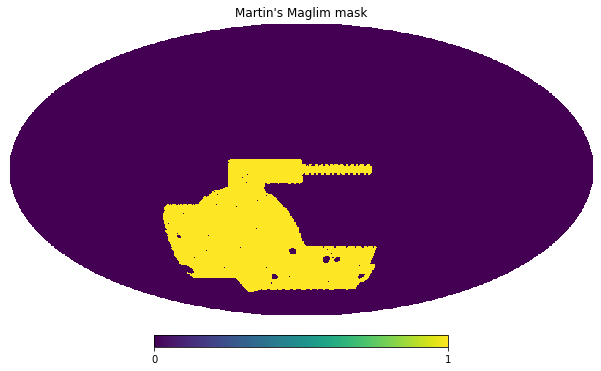

In [27]:
# provided by Martin Rodriguez Monroy
martin_dir = f"/Users/arne/data/DESY3/masks/maglim_mask_nside_{n_side}.fits.gz"

data, header = fits.getdata(martin_dir, header = True)
martin_inds = data["HPIX"]

martin_mask = np.zeros(n_pix)
martin_mask[martin_inds] = 1
hp.mollview(martin_mask, title="Martin's Maglim mask")



# inspect the file

In [28]:
with h5py.File(pixels_dir, "r") as f:
    data_vec_ids = f["metacal/map_cut_outs/data_vec_ids"][:]

print(data_vec_ids.shape)

(463872,)


In [29]:
with h5py.File(pixels_dir, "r") as f:
    print(f.keys())
    print(f["metacal"].keys(), "\n")

    print(f["metacal/masks"].keys())
    print(f["metacal/map_cut_outs"].keys(), "\n")

    print(f["metacal/map_cut_outs/patches/RING"].keys())
    print(f["metacal/map_cut_outs/RING_ids_to_data_vec"].keys(), "\n")

    print(f["metacal/map_cut_outs/data_vec_ids"], "\n")

    temp = f["metacal/map_cut_outs"]


<KeysViewHDF5 ['metacal']>
<KeysViewHDF5 ['map_cut_outs', 'masks']> 

<KeysViewHDF5 ['NEST', 'RING']>
<KeysViewHDF5 ['RING_ids_to_data_vec', 'data_vec_ids', 'patches']> 

<KeysViewHDF5 ['desy3metacal1', 'desy3metacal2', 'desy3metacal3', 'desy3metacal4']>
<KeysViewHDF5 ['desy3metacal1', 'desy3metacal2', 'desy3metacal3', 'desy3metacal4']> 

<HDF5 dataset "data_vec_ids": shape (463872,), type "<i4"> 



In [30]:
with h5py.File(pixels_dir, "r") as f:
    print(f["metacal/map_cut_outs/patches/RING"].keys())

    for value in f["metacal/map_cut_outs/patches/RING"].values():
        print(type(value))

<KeysViewHDF5 ['desy3metacal1', 'desy3metacal2', 'desy3metacal3', 'desy3metacal4']>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
